#### Requirements

In [1]:
import sys
import os

import geopandas as gpd
import pandas as pd
import numpy as np
import datetime as dt

from sklearn.linear_model import LinearRegression

#### Constants

In [2]:
# General
BASE_PATH = os.path.dirname(os.getcwd())

# Mapping
CHANGE_TYPE_MAP = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
       'Mega Projects': 5}
CHANGE_STATUS_MAP = {'Greenland': 0.0, 'Land Cleared': 1.0, 'Excavation': 1.0, 'Materials Dumped': 3.0, 'Prior Construction': 3.0, 'Materials Introduced': 4.0, 'Construction Started': 5.0, 'Construction Midway': 6.0, 'Construction Done': 8.0, 'Operational': 10.0, None: None}

# Data
COLORS = ['red', 'green', 'blue']
METRICS = ['std', 'mean']
GEOGRAPHY_TYPES = ['Dense Forest', 'Grass Land', 'Sparse Forest', 'Farms', 'River',
                   'Coastal', 'Lakes', 'Barren Land', 'Desert', 'Hills', 'Snow'] 
URBAN_TYPES = ['Sparse Urban', 'Rural', 'Dense Urban', 'Urban Slum', 'Industrial']

# Columns groups
COLUMNS_TO_DROP = []
DATE_COLUMNS = ['date0', 'date1', 'date2', 'date3', 'date4']
CHANGE_STATUS_COLUMNS = ['change_status_date0', 'change_status_date1', 'change_status_date2', 'change_status_date3', 'change_status_date4']
CHANGE_STATUS_VALUE_COLUMNS = ['change_status_value_date0', 'change_status_value_date1', 'change_status_value_date2', 'change_status_value_date3', 'change_status_value_date4']

# Output file
OUTPUT_FILE = 'preprocessed_train.geojson'

#### Reading Data

In [3]:
## Read data
train_df_read = gpd.read_file(f'{BASE_PATH}/data/train.geojson', index_col=0)
#test_df = gpd.read_file(f'{BASE_PATH}/data/test.geojson', index_col=0)

In [82]:
train_df = train_df_read.copy(deep=True)
# Safety
MAPPED = False

In [96]:
## Create new polygon features
from shapely.geometry import Polygon, LinearRing
from scipy.spatial.distance import euclidean

# Direct features
train_df['area'] = train_df['geometry'].area
train_df['length'] = train_df['geometry'].length
train_df['centroid_x'] = train_df['geometry'].centroid.x
train_df['centroid_y'] = train_df['geometry'].centroid.y

# Shape features
bounds = train_df['geometry'].bounds
train_df['angle'] = np.arctan((bounds['maxy']-bounds['miny'])/(bounds['maxx']-bounds['minx']))
train_df['compactness'] = 4 * np.pi * (train_df['area'] / train_df['length']**2) # the bigger, the closer to square

def is_paralelogram(polygon):
    it_is = True
    LIMIT = 1e-2
    # Get the outer boundary coordinates
    coords = polygon.exterior.coords[:-1]  # Exclude the closing coordinate
    
    # Check if the polygon has four sides
    num_vertices = len(coords)
    if  num_vertices != 4:  # a paralelogram should have 4 vertices
        it_is = False
        return (it_is, num_vertices, 10*LIMIT, num_vertices*4*LIMIT)

    # Calculate the lengths of the sides
    side_lengths = [euclidean(coords[i],coords[(i+1)%4]) for i in range(4)]  # Calculate the length between each pair of adjacent vertices
    
    # Check if opposite sides have equal length (index 0 and 2, index 1 and 3)
    length_dif = abs(side_lengths[0] - side_lengths[2]) + abs(side_lengths[1] - side_lengths[3])/polygon.length
    if length_dif > LIMIT:
        it_is = False
    
    return (it_is, num_vertices, length_dif, length_dif)

tmp = train_df['geometry'].apply(is_paralelogram)
# Extract the tuple into three different columns
train_df['paralelogram'], train_df['num_vertices'], train_df['length_dif1'], train_df['length_dif2'] = zip(*tmp)

## DROP
train_df = train_df.drop(columns=['geometry'])

/tmp/ipykernel_32942/3752073231.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  train_df['area'] = train_df['geometry'].area
/tmp/ipykernel_32942/3752073231.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  train_df['length'] = train_df['geometry'].length
/tmp/ipykernel_32942/3752073231.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  train_df['centroid_x'] = train_df['geometry'].centroid.x
/tmp/ipykernel_32942/3752073231.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries 

<Figure size 1000x600 with 0 Axes>

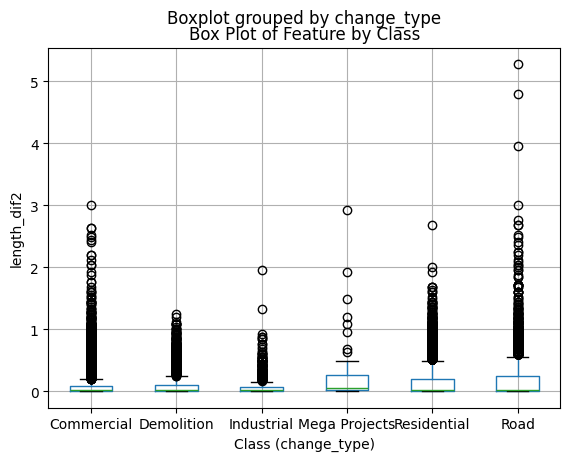

In [101]:
import matplotlib.pyplot as plt

feature = "length_dif2"

# Plotting box plots for each class in "change_type"
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
train_df.boxplot(column=feature, by='change_type', grid=False,)

# Adding labels and title
plt.xlabel('Class (change_type)')
plt.ylabel(feature)
plt.title('Box Plot of Feature by Class')
plt.grid(True, which='both')


# Show the plot
#plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

#### Data preprocessing

In [5]:
## Clean samples with NaN in column  "change_type"
#df_cleaned = df.dropna(subset=['change_type'])

In [6]:
## Map change_type
if ~MAPPED:
    train_df['change_type'] = train_df['change_type'].map(CHANGE_TYPE_MAP)
    MAPPED = True

In [7]:
## One-hot encoding
for geograph_type in GEOGRAPHY_TYPES:
    train_df[geograph_type] = train_df['geography_type'].apply(lambda x: 1 if geograph_type in x else 0)
for urban_type in URBAN_TYPES:
    train_df[urban_type] = train_df['urban_type'].apply(lambda x: 1 if urban_type in x else 0)
## DROP
train_df = train_df.drop(columns=['geography_type', 'urban_type'])

In [8]:
## Create change_status_values
for i in range(len(CHANGE_STATUS_COLUMNS)):
    train_df[CHANGE_STATUS_VALUE_COLUMNS[i]] = train_df[CHANGE_STATUS_COLUMNS[i]].map(CHANGE_STATUS_MAP)
## DROP
train_df = train_df.drop(columns=CHANGE_STATUS_COLUMNS)

In [10]:
## Convert date from string to seconds
train_df[DATE_COLUMNS] = train_df[DATE_COLUMNS].apply(lambda x: pd.to_datetime(x, format='%d-%m-%Y', errors='coerce')).apply(np.float64)

In [11]:
from sklearn.impute import KNNImputer

# Group the DataFrame by "change_type"
grouped = train_df.groupby("change_type")

# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=5,missing_values=np.nan)  # You can adjust the number of neighbors as needed

# Initialize an empty list to store the imputed DataFrames
imputed_dfs = []

# Iterate over each group
for change_type, group in grouped:
    # Drop the "change_type" column before imputation
    group_features = group.drop(columns=["change_type"])
    
    # Impute NaN values within the group
    imputed_values = imputer.fit_transform(group_features)
    
    # Create a DataFrame with imputed values
    imputed_df = pd.DataFrame(imputed_values, columns=group_features.columns, index=group_features.index)
    
    # Concatenate "change_type" column back to the imputed DataFrame
    imputed_df["change_type"] = change_type
    
    # Append the imputed DataFrame to the list
    imputed_dfs.append(imputed_df)

# Concatenate all imputed DataFrames into a single DataFrame
imputed_train_df = pd.concat(imputed_dfs)
train_df = imputed_train_df.copy()

# Verify if there are still NaN values after imputation
if train_df.isnull().values.any():
    print("There are still NaN values remaining after imputation.")
    print(train_df[train_df.isnull().any(axis=1)])
else:
    print("All NaN values have been imputed successfully.")

TypeError: float() argument must be a string or a real number, not 'Polygon'

In [ ]:
## FIX DATES OUT OF ORDER
def sort_dates(row):

    # Sort columns by date
    columns_order = np.argsort(row[DATE_COLUMNS].values)
    new_row = row.copy(deep=True)

    # Update date and change_status order
    for i in range(5):
        new_row[f'date{i}'] = row[f'date{columns_order[i]}']
        new_row[f'change_status_value_date{i}'] = row[f'change_status_value_date{columns_order[i]}']

    # Update color metrics order
    for metric in METRICS:
        for color in COLORS:
            for i in range(1, 6):
                new_row[f'img_{color}_{metric}_date{i}'] = row[f'img_{color}_{metric}_date{columns_order[i-1]+1}']

    return new_row

train_df = train_df.apply(sort_dates, axis=1)
train_df = train_df.copy()

In [ ]:
train_df['date0'].dtype

dtype('float64')

In [ ]:
## Create deltas color[std, mean] 
for metric in METRICS:
    for color in COLORS:
        for i in range(2, 6):
            delta = train_df[f'img_{color}_{metric}_date{i}'] - train_df[f'img_{color}_{metric}_date{i-1}']
            train_df[f'img_{color}_{metric}_delta{i}'] = delta.apply(np.float64)
        train_df[f'img_{color}_{metric}_delta_total'] = (train_df[f'img_{color}_{metric}_date5'] - train_df[f'img_{color}_{metric}_date1']).apply(np.float64)

## Create deltas time 
for i in range(1, 5):
    train_df[f'date_delta{i}'] = (train_df[f'date{i}'] - train_df[f'date{i-1}']).apply(np.float64)
train_df['date_delta_total'] = (train_df[f'date4'] - train_df[f'date0']).apply(np.float64)

In [ ]:
## Standardizing colors mean by the proportion
for i in range(1, 6):
    color_sum = train_df[f'img_blue_mean_date{i}'] + train_df[f'img_green_mean_date{i}'] + train_df[f'img_red_mean_date{i}']
    for color in COLORS:
        train_df[f'img_{color}_mean_prop_date{i}'] = train_df[f'img_{color}_mean_date{i}']/color_sum

## Create img_{color}_mean_prop_rate
num_samples = train_df.shape[0]
ones = np.ones((num_samples,5,1))

for color in COLORS:
    coef = np.zeros((num_samples))
    COLOR_MEAN_COLUMNS = [f'img_{color}_mean_prop_date{i}' for i in range (1,6)]
    
    Y = np.array(train_df[COLOR_MEAN_COLUMNS].astype(float))
    X = np.array(train_df[DATE_COLUMNS].apply(np.float64))[:,:,np.newaxis]
    X = np.dstack((ones,X))
    nan_mask = np.isnan(Y) | np.isnan(X[:,:,1])
    X[nan_mask,:] = 0
    Y[nan_mask] = 0

    eye = np.eye(2)*0.0001
    for i in range(num_samples):
        x = X[i].reshape((5,2))
        y = Y[i].reshape((5))
        coef[i] = (np.linalg.inv(eye+x.T@x)@x.T@y)[1]
        
    train_df[f'img_{color}_mean_prop_rate'] = coef
    
## Create img_{color}_{metric}_rate
for metric in METRICS:
    for color in COLORS:
        coef = np.zeros((num_samples))
        COLOR_METRIC_COLUMNS = [f'img_{color}_{metric}_date{i}' for i in range (1,6)]
        
        Y = np.array(train_df[COLOR_METRIC_COLUMNS].astype(float))
        X = np.array(train_df[DATE_COLUMNS].apply(np.float64))[:,:,np.newaxis]
        X = np.dstack((ones,X))
        nan_mask = np.isnan(Y) | np.isnan(X[:,:,1])
        X[nan_mask,:] = 0
        Y[nan_mask] = 0

        eye = np.eye(2)*0.0001
        for i in range(num_samples):
            x = X[i].reshape((5,2))
            y = Y[i].reshape((5))
            coef[i] = (np.linalg.inv(eye+x.T@x)@x.T@y)[1]
            
        train_df[f'img_{color}_{metric}_rate'] = coef

In [ ]:
## Create civilization_rate
num_samples = train_df.shape[0]
coef = np.zeros((num_samples))
time_ctt = 1e9*60*90*24
ones = np.ones((num_samples,5,1))

Y = np.array(train_df[CHANGE_STATUS_VALUE_COLUMNS].astype(float))
Y_nan_mask = np.isnan(Y)
X = np.array(train_df[DATE_COLUMNS].apply(np.float64))[:,:,np.newaxis]/time_ctt
X = np.dstack((ones,X))
X[Y_nan_mask,:] = 0
Y[Y_nan_mask] = 0

eye = np.eye(2)*0.0001
for i in range(num_samples):
    x = X[i].reshape((5,2))
    y = Y[i].reshape((5))
    coef[i] = (np.linalg.inv(eye+x.T@x)@x.T@y)[1]
    #print(y, train_df["change_type"].iloc[i])
train_df["civilizating_rate"] = coef


#### Finalization and Save

In [ ]:
## Drop uncessary columns
#train_df = train_df.drop(columns=COLUMNS_TO_DROP)


In [ ]:
train_df['date_delta1'].dtype

dtype('float64')

In [ ]:
## ANOVA and information gain for each feature
from scipy.stats import f_oneway
#from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

# Assuming 'change_type' is the column name for classification effects
change_type_column = 'change_type'
#CONTINUOUS_FEATURES = ['area_to_length_ratio' ,'area' ,'angle' ,'compactness', 'length']

# Group the data by 'change_type'
grouped_data = train_df.groupby(change_type_column)

# List to store F-values
f_values = []
#gain_of_info = []

# Loop through each feature (column) and calculate F-value
for feature_column in train_df.columns:
    if feature_column != change_type_column and feature_column != 'geometry':  
        # ANOVA
        nan_mask = np.isnan(train_df[feature_column])
        feature_values = [group[feature_column].dropna() for _, group in grouped_data]
        f_statistic, p_value = f_oneway(*feature_values)
        # Gain of Info
        
        
        #discrete_bool = feature_column not in CONTINUOUS_FEATURES and 'std' not in feature_column and 'rate' not in feature_column and 'prop' not in feature_column
        #gofinfo = mutual_info_classif(train_df[feature_column][~nan_mask].values.reshape(-1, 1), train_df[change_type_column][~nan_mask].astype(str),discrete_features=discrete_bool)
        
         
        #     gofinfo = mutual_info_regression(train_df[feature_column][~nan_mask].values.reshape(-1, 1), train_df[change_type_column][~nan_mask])
        # else:
        #     gofinfo = mutual_info_classif(train_df[feature_column][~nan_mask].values.reshape(-1, 1), train_df[change_type_column][~nan_mask])
            
        f_values.append((feature_column, f_statistic, p_value))


## Convert to DataFrame for easier analysis
f_values_df = pd.DataFrame(f_values, columns=['Feature', 'F-value', 'P-value'])

In [ ]:
# Print or analyze the F-values DataFrame
sorted_2 = f_values_df['F-value'].argsort()
sorted_f_values_df = f_values_df.sort_values(by='F-value')
sorted_f_values_df.to_csv("ANOVA.csv", sep='\t', index=False)

In [ ]:
df = train_df[[f'date_delta{i}' for i in range(1,5)]]
# Filter rows with negative values
negative_rows = df[(df < 0).any(axis=1)]

# Print the filtered rows
print("Rows with negative values:")
negative_rows


Rows with negative values:


,date_delta1,date_delta2,date_delta3,date_delta4


In [ ]:
## Save output file
#train_df.to_parquet('preprocessed_data.parquet') 

#### FEATURE SELECTION

In [ ]:
t_df = train_df.copy(deep=True)

TypeError: Axes.boxplot() got an unexpected keyword argument 'log'

<Figure size 1000x600 with 0 Axes>

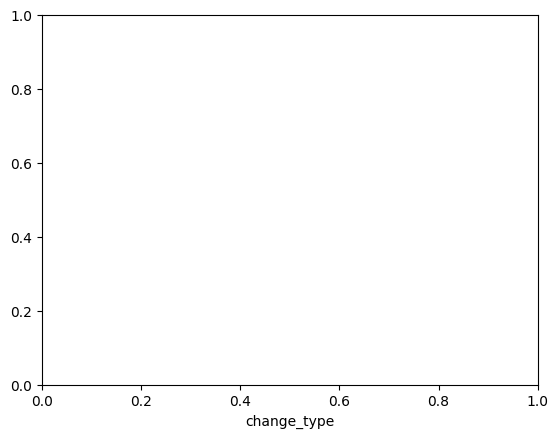

In [ ]:
BINARY_FEATURES = [
    'Dense Forest', 
    'Grass Land', 
    'Sparse Forest', 
    'Farms', 
    'River',
    'Coastal', 
    'Lakes', 
    'Barren Land', 
    'Desert', 
    'Hills', 
    'Snow',
    'Sparse Urban',
    'Rural',
    'Dense Urban',
    'Urban Slum',
    'Industrial'
]
